## House Price Prediction - Assignment Solution

sections: 
- Data understanding
- Data preprocessing
- Model building 
- evaluation

### 1. Data Understanding

In [1]:
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Read dataset
house = pd.read_csv("train.csv", na_values="NAN")

In [4]:
# first few rows
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
print(house.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Summary of the dataset : 1460 rows, 81 columns

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

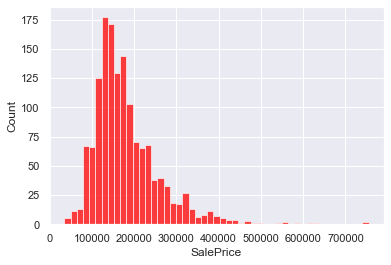

In [69]:
sns.histplot(house['SalePrice'],color='red')

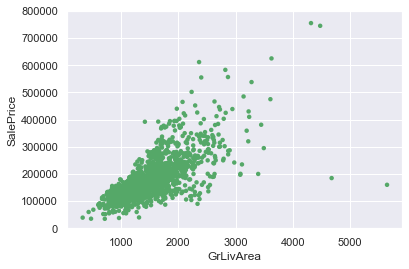

In [62]:
var = 'GrLivArea'
data = pd.concat([house['SalePrice'], house[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000),c='g',edgecolor='None');

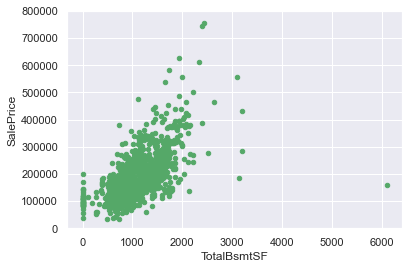

In [70]:
var = 'TotalBsmtSF'
data = pd.concat([house['SalePrice'], house[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000),c='g');

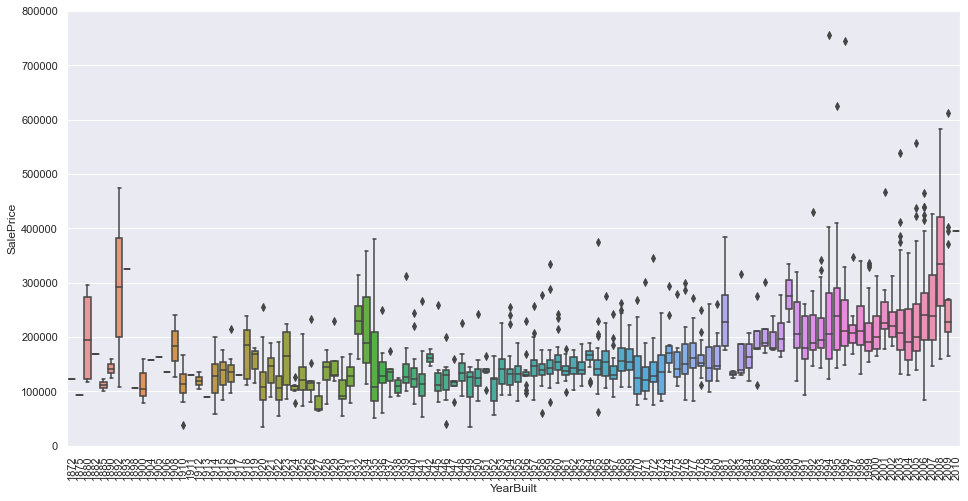

In [85]:
var = 'YearBuilt'
data = pd.concat([house['SalePrice'], house[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

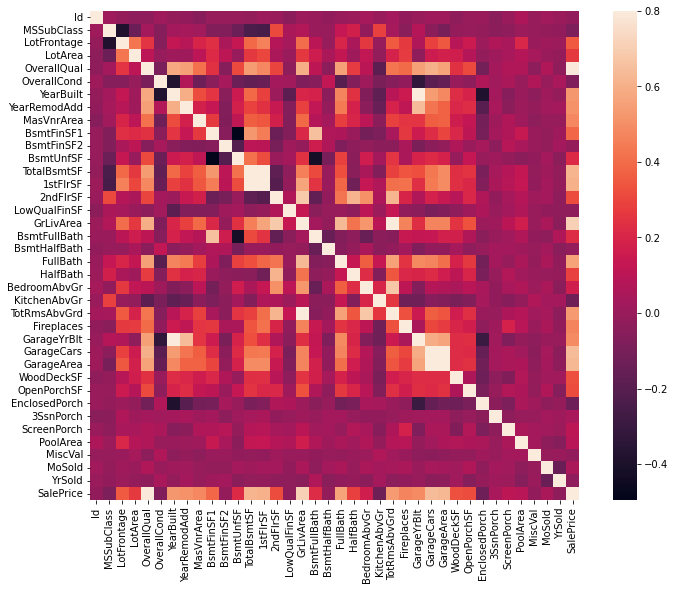

In [23]:
#correlation matrix
corrmat = house.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

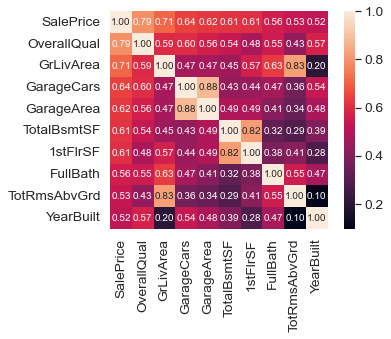

In [24]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(house[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

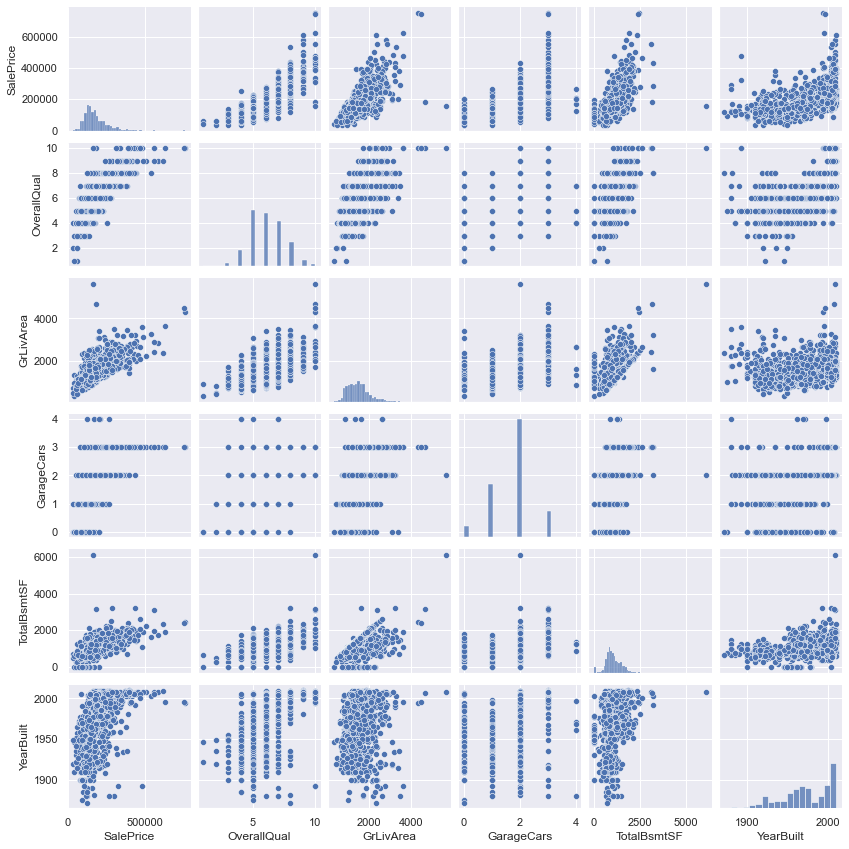

In [84]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'YearBuilt']
sns.pairplot(house[cols], size =2)
plt.show();

# Missing data

In [87]:
total = house.isnull().sum().sort_values(ascending=False)
percent = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Id,0,0.0
MSSubClass,0,0.0
GarageYrBlt,0,0.0
GarageType,0,0.0
FireplaceQu,0,0.0
Fireplaces,0,0.0
Functional,0,0.0
TotRmsAbvGrd,0,0.0
KitchenQual,0,0.0
KitchenAbvGr,0,0.0


### Place Where NaN Means Something and fill it with None instead of dropping

In [88]:
null_meaning = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature"]

In [89]:
for i in null_meaning:
    house[i].fillna("None", inplace=True)
    house[i].fillna("None", inplace=True)

In [90]:
total = house.isnull().sum().sort_values(ascending=False)
percent = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(6)

,Total,Percent
Id,0,0.0
MSSubClass,0,0.0
GarageYrBlt,0,0.0
GarageType,0,0.0
FireplaceQu,0,0.0
Fireplaces,0,0.0


LotFrontage has too many Null values so we drop it.

In [91]:
house.drop("LotFrontage", axis=1, inplace=True)

KeyError: "['LotFrontage'] not found in axis"

In [ ]:
#missing data
total = house.isnull().sum().sort_values(ascending=False)
percent = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

GarageYrBlt, MasVnrArea, and MasVnrType all have a fairly decent amount of missing values. 

In [ ]:
#MasVnrType is categorical so we can replace the missing values with "None", as we did before. We can fill the others with median.
house["GarageYrBlt"].fillna(house["GarageYrBlt"].median(), inplace=True)
house["MasVnrArea"].fillna(house["MasVnrArea"].median(), inplace=True)
house["MasVnrType"].fillna("None", inplace=True)

In [ ]:
#missing data
total = house.isnull().sum().sort_values(ascending=False)
percent = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

Now that only one row has a null entry, we will drop the row.

In [ ]:
house.dropna(inplace=True)

In [ ]:
#missing data
total = house.isnull().sum().sort_values(ascending=False)
percent = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

In [92]:
print(house.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1459 non-null   object 
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   Alley          1459 non-null   object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1459 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 non-null   int64  
 18  YearBuil

### Now we shall find the data type of all features remaining

In [93]:
train = house.dtypes
num_train = train[(train == 'int64') | (train == float)] 
cat_train = train[train == object] 

In [94]:
pd.DataFrame(train).reset_index().set_index(0).reset_index()[0].value_counts()

object     43
int64      35
float64     2
Name: 0, dtype: int64

In [95]:
numerical_values_train = list(num_train.index)

In [96]:
print(numerical_values_train)

['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


These are all the numerical features in our data.

In [97]:
categorical = list(cat_train.index)
print(categorical)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


# Data Preparation

Data preprocessing, We need to create feature vectors in order to get the data ready to be fed into our model as training data. This requires us to convert the categorical values into representative numbers.

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

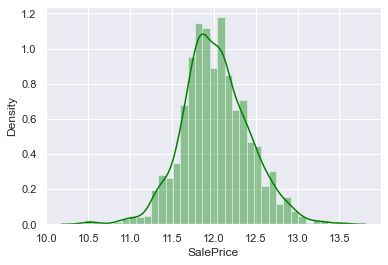

In [98]:
sns.distplot(np.log(house["SalePrice"]),color='green')

It appears that the target, SalePrice, is very skewed and a transformation like a logarithm would make it more normally distributed. Machine Learning models tend to work much better with normally distributed targets, rather than greatly skewed targets. By transforming the prices, we can boost model performance.

In [99]:
house["TransformedPrice"] = np.log(house["SalePrice"])

In [101]:
print(categorical)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [103]:
for i in categorical:
    feature_set = set(house[i])
    for j in feature_set:
        feature_list = list(feature_set)
        house.loc[house[i] == j, i] = feature_list.index(j)

In [104]:
house.head()

,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TransformedPrice
0,1,60,2,8450,0,0,1,0,0,2,...,0,3,4,0,2,2008,0,4,208500,12.247694
1,2,20,2,9600,0,0,1,0,0,4,...,0,3,4,0,5,2007,0,4,181500,12.109011
2,3,60,2,11250,0,0,0,0,0,2,...,0,3,4,0,9,2008,0,4,223500,12.317167
3,4,70,2,9550,0,0,0,0,0,3,...,0,3,4,0,2,2006,0,5,140000,11.849398
4,5,60,2,14260,0,0,0,0,0,4,...,0,3,4,0,12,2008,0,4,250000,12.429216


Great! It seems like we have changed all the categorical strings into a representative number. We are ready to build our models!

# Model Building



In [107]:
X = house.drop(["Id", "SalePrice", "TransformedPrice"], axis=1).values
y = house["TransformedPrice"].values

In [109]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

In [110]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

In [111]:
# Importing the relevant libraries
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model

In [112]:
# Applying Lasso
lasso = Lasso()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [113]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.031630,0.019760,0.001229,0.001697,0.0001,{'alpha': 0.0001},-0.082760,-0.099141,-0.102958,-0.095679,...,-0.095396,0.006812,2,-0.086832,-0.082514,-0.076051,-0.085036,-0.083179,-0.082723,0.003661
1,0.012965,0.009534,0.000141,0.000283,0.001,{'alpha': 0.001},-0.085183,-0.100457,-0.100764,-0.095193,...,-0.094399,0.005980,1,-0.088574,-0.083937,-0.077750,-0.084792,-0.084795,-0.083970,0.003500
2,0.006545,0.008028,0.000000,0.000000,0.01,{'alpha': 0.01},-0.098168,-0.105439,-0.106070,-0.096480,...,-0.099550,0.005510,3,-0.096689,-0.094014,-0.089426,-0.089491,-0.095374,-0.092999,0.003012
3,0.029173,0.014297,0.001200,0.001030,0.05,{'alpha': 0.05},-0.101413,-0.118728,-0.121857,-0.114723,...,-0.111885,0.008347,4,-0.107151,-0.105380,-0.101665,-0.102657,-0.107026,-0.104776,0.002247
4,0.014875,0.010092,0.006568,0.008045,0.1,{'alpha': 0.1},-0.103694,-0.124151,-0.126851,-0.120797,...,-0.116834,0.009042,6,-0.114838,-0.110302,-0.106150,-0.106453,-0.113192,-0.110187,0.003490


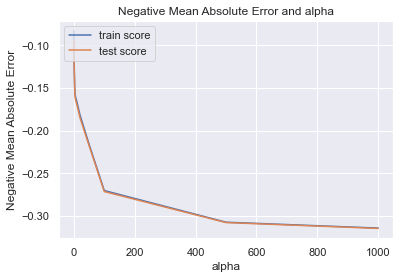

In [114]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [115]:
alpha = 50

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=50)

In [116]:
lasso.coef_

array([-0.00000000e+00,  0.00000000e+00,  4.02426915e-06, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        1.41724335e-04, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        2.68173575e-04,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -

In [117]:
# Applying Ridge
ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [118]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=200]
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.026285,0.024479,0.003317,0.001803,0.0001,{'alpha': 0.0001},-0.083137,-0.099290,-0.103343,-0.086557,...,-0.093936,0.007745,2,-0.086722,-0.082361,-0.075909,-0.084983,-0.083221,-0.082639,0.003685
1,0.013423,0.005504,0.003139,0.001753,0.001,{'alpha': 0.001},-0.083134,-0.099290,-0.103342,-0.083153,...,-0.093255,0.008479,1,-0.086725,-0.082363,-0.075909,-0.085015,-0.083221,-0.082647,0.003689
2,0.013485,0.006876,0.000398,0.000796,0.01,{'alpha': 0.01},-0.083094,-0.099291,-0.103334,-0.092288,...,-0.095077,0.006965,3,-0.086753,-0.082384,-0.075915,-0.085088,-0.083236,-0.082675,0.003702
3,0.011732,0.007137,0.001834,0.001620,0.05,{'alpha': 0.05},-0.083016,-0.099311,-0.103300,-0.095076,...,-0.095631,0.006858,4,-0.086875,-0.082476,-0.075941,-0.085114,-0.083304,-0.082742,0.003724
4,0.006501,0.003494,0.001498,0.001098,0.1,{'alpha': 0.1},-0.083258,-0.099337,-0.103334,-0.095494,...,-0.095795,0.006778,5,-0.087021,-0.082594,-0.076011,-0.085122,-0.083390,-0.082828,0.003733


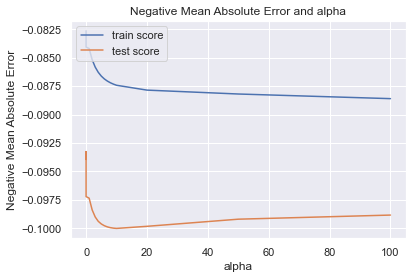

In [119]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [120]:
alpha = 10
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_

array([-3.97682374e-04,  2.29795341e-02,  1.95678182e-06, -5.82171140e-02,
       -1.01703189e-02, -6.17565628e-03, -1.00738518e-02, -1.27593772e-02,
       -1.01951954e-02, -6.09389480e-03, -3.24679331e-03, -9.94219430e-03,
       -5.47066075e-02, -8.52722045e-03, -2.84837469e-03,  7.08104639e-02,
        4.47876451e-02,  2.68249483e-03,  1.13033476e-03,  3.43207471e-03,
        3.96392227e-02, -3.02586565e-03,  8.04075868e-04, -7.03839895e-03,
        4.02900220e-05, -1.52933275e-02,  9.95576905e-03, -6.80752202e-03,
        8.96052738e-03, -1.42882281e-02, -1.03305134e-02,  3.47740701e-03,
        3.33648962e-05, -7.35131551e-03,  3.19063665e-05,  3.00580362e-06,
        6.82770670e-05,  9.77192939e-03, -6.37165201e-03, -5.81434488e-02,
        8.87192778e-03,  5.32974868e-05,  6.19738508e-05,  3.59657038e-05,
        1.51237044e-04,  6.04069226e-02,  1.90112337e-02,  3.64618651e-02,
        2.10264233e-02,  4.58604501e-03, -2.36357177e-02, -1.18662979e-03,
        3.97566874e-03, -